## Introduction

This is kaggle already finished competition. 

https://www.kaggle.com/c/web-traffic-time-series-forecasting

In this competition there were two pairs of train/test dataset, because competition was divided into two parts. I will use only second dataset - train_2. 

There are around 150000 time series and it is guite a task to model all of them. So, I will divide them on several groups. And we will assume, that group (mean value among all series in the group for each day) can be modelled and the result can be applied to each series in the group. 

I will explore separation by language, by access and by type of the cite (wikipedia, wikimedia or mediawiki). I am going to model and explore onlu groups, but for the further investigation in each group the most popular/unpopular pages can be modelled separately. 

The predictions are done with fbProphet and compared to LSTM predictions (without any parameter tuning). 

In [ ]:
## Table of contents. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# for extracting language and access
import re
%matplotlib inline

import scipy.stats as scs
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

This function below is for memory optimization for pandas dataframe. It makes huge impact when you have a lot of categorical variables, which are insufficiently storaged as strings. 

In [2]:
def memory_optimization(data, cat_cols):
    converted_cat = [0]*len(cat_cols)
    
    #float64 -> float32
    data_float = data.select_dtypes(include=['float'])
    # just for this particular datasate I am downcastng to int,
    # otherwise you need to put float there 
    converted_float = data_float.apply(pd.to_numeric, downcast='float')
    data[converted_float.columns] = converted_float
    
    #int64 -> int8 only (0,1) values
    data_int = data.select_dtypes(include=['int64'])
    converted_int = data_int.apply(pd.to_numeric, downcast='integer')
    data[converted_int.columns] = converted_int
    
    #array of strings -> categorical
    for _ in range(len(cat_cols)):
        converted_cat[_] = data[cat_cols[_]].astype('category')
        data[cat_cols[_]] = converted_cat[_]

This function is for inverting boxcox convertion. 

In [3]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

This is MAPE and it doesn't work with y_true = 0, however it is quite representative metric. 

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

This metric is used for this particular contest. It has some problems, for example it penalises under estimation more than over estimation. There is a good kernel about its problems https://www.kaggle.com/cpmpml/smape-weirdness, and this is fast realization from https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/37232

In [5]:
#Symmetric mean absolute percentage error
from numba import jit
import math

@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(len(y_true)):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    # 200 here because of kagle convention, however 100 can also be used 
    out *= (200.0 / len(y_true))
    return out


Loading the data. 


In [6]:
train = pd.read_csv('train_2.csv')

In [7]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


As we can see train data contain NaN values, and in the competition it is mentioned that there is
no separation between zero and NaN. That is why I'm filling NaN with zeros. 

In [8]:
train.fillna(0, inplace  = True)

From the page name we can extract some information. First of all it is a language. 

In [9]:
def get_language(page):
    # two letters before .wikipedia.org
    # example of res'zh.wikipedia.org'
    res = re.search('[a-z][a-z].wikipedia.org',page)
    # if we did find it 
    if res:
        # output is two letters 
        return res[0][0:2]
    # this is in case we didn't find it 
    return 'na'

Now we can get the type of access.

In [10]:
def get_access(page):
    res = re.search('(mediawiki|wikipedia|wikimedia).org_[a-z]*',page)
    # of we did find it 
    if res:
        return res[0]
    # this is in case we didn't find it 
    return 'na'

In [11]:
train['lang'] = train.Page.map(get_language)
train['lang'].value_counts()


en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: lang, dtype: int64

For language it works fine. 
We can see 7 languages and the biggest number of pages is in English. 
There are also "na" values, because we have not only wikipedia.org pages, but also wikimedia.org and mediawiki.org. 

However for language investigation I think that's fine. 

In [12]:
train['access']  = train.Page.map(get_access)
print(train['access'].value_counts())

wikipedia.org_all        65713
wikipedia.org_mobile     30923
wikipedia.org_desktop    30572
wikimedia.org_all         5101
mediawiki.org_all         3501
wikimedia.org_mobile      2913
wikimedia.org_desktop     2541
mediawiki.org_mobile      2103
mediawiki.org_desktop     1696
Name: access, dtype: int64


That works also fine. As we can see there are three types of access for all thre websites. 
Let's do separate variables for cite type and access type.

In [13]:
train['cite_type'] = train.access.map(lambda x: x[:9])
train['access_type'] = train.access.map(lambda x: x[14:])


print(train['cite_type'].value_counts())
print(train['access_type'].value_counts())

wikipedia    127208
wikimedia     10555
mediawiki      7300
Name: cite_type, dtype: int64
all        74315
mobile     35939
desktop    34809
Name: access_type, dtype: int64


We don't need column access and Page anymore. 

In [14]:
train.drop("access",axis = 1, inplace = True)
train.drop("Page",axis = 1, inplace = True)

Now it is time for little memory optimization. For all that categorical info, which we gained. 

In [15]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 806 entries, 2015-07-01 to access_type
dtypes: float64(803), object(3)
memory usage: 914.5 MB


In [16]:
cat_cols = ['cite_type','access_type','lang']
# it will change the train dataset
memory_optimization(train, cat_cols)

In [17]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 806 entries, 2015-07-01 to access_type
dtypes: category(3), float32(803)
memory usage: 444.8 MB


Now when we gained language, access and type of web site, we will try to do something with gained groups. 

## Languages

In [30]:
lang_sets = {}
for cat in train.lang.cat.categories:
    lang_sets[cat] = train[train.lang==cat]

Calculating mean value per day for each language group. 

In [31]:
lang_sum = {}
for key in lang_sets:
    # 0 - it is column Pages 
    # -1, -2 - language and acceess pages - we just cutting off some of the columns 
    lang_sum[key] = lang_sets[key].sum(axis=0)[1:-3] / lang_sets[key].shape[0]

Let's plot gained groups. 

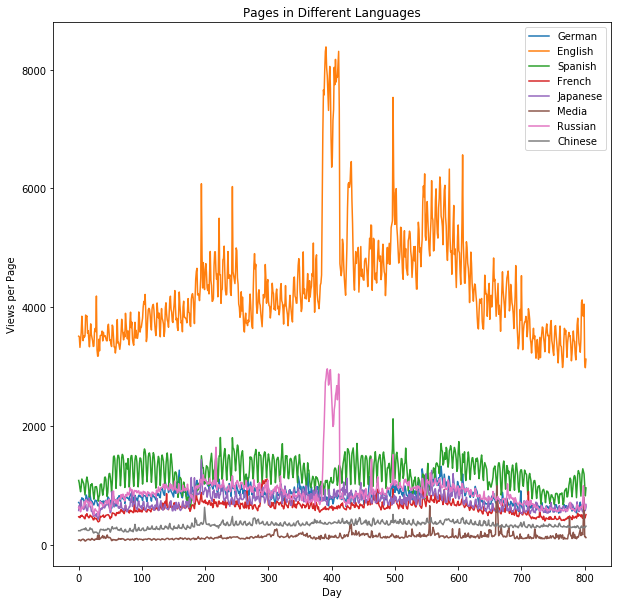

In [ ]:
fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in lang_sum:
    plt.plot(lang_sum[key].values,label = labels[key] )
    
plt.legend()
plt.show()

We can see that English pages differ a lot from the other ones. Also in English and Russian page views there was a pick, 
may be because of election or Olympics, there are different variants. 

### Forecasting

Let's divide data to test and train. 

No shuffle just 70, 30, for simplicity.

In [22]:
# Why here -4?! 
# Because time is a columns in train dataset and there are 4 extra columns, which are not time
n_train = int((train.shape[1] - 4)*0.7)
n_test = (train.shape[1] - 4) - n_train

Creating train/test datasets for each language group. 

In [ ]:
lang_test = {}
lang_train = {}

for key in lang_sets:
    lang_train[key] = lang_sum[key][:n_train]
    lang_test[key] = lang_sum[key][:-n_train] 
    lang_train[key] = lang_train[key].map(lambda x: float(x))
    lang_test[key] = lang_test[key].map(lambda x: float(x))

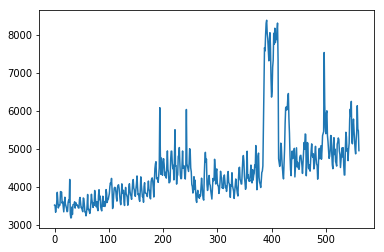

In [ ]:
plt.plot(lang_train['en'].values)

We can see, that our training data will contain that fun pick.

I've tried to do predictions with that data in it, but the results were poor.

I guess, that to explain that kind of data you need to use some extra information. 

### Train cleaning 


Let's compute mean, std and median of the train data. 

In [ ]:
median = {}
mean = {}
std = {}
hight_picks = {}

for key in lang_sets:
    median[key] = np.median(lang_train[key])
    mean[key] = np.mean(lang_train[key])
    std[key] = np.std(lang_train[key])
    # it is for outliers 
    hight_picks[key] = [lang_train[key][_] \
                        if abs(lang_train[key][_])>mean[key]+2*std[key] \
                        else np.nan for _ in range(n_train)]


Let's plot all dots above mean+2*std line. Our high pick have to be there. 

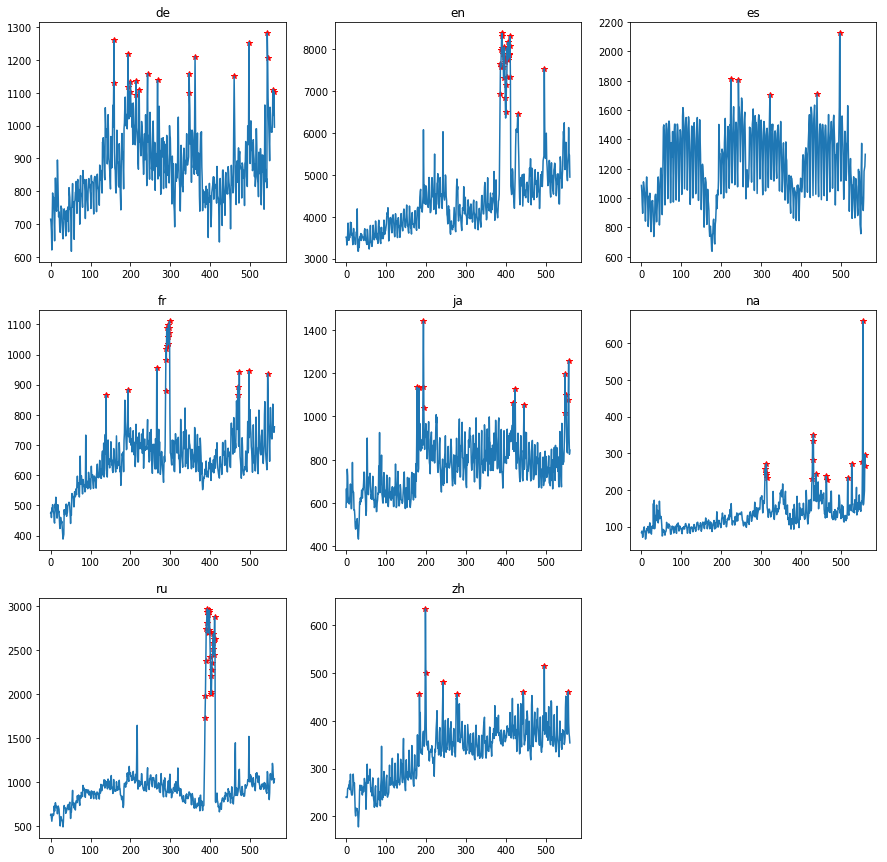

In [ ]:
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in lang_sets:
    plt.subplot(3, 3, i)
    plt.plot(hight_picks[key],'r*') 
    plt.plot(lang_train[key].values)
    plt.title(key)
    i+=1

Now we will replace them with the mean value of the series. 

In [ ]:
# also we will save time 
# as we replacing object with the list
dt = lang_train['en'].index
for key in lang_sets:
    lang_train[key] = [median[key]\
                       if abs(lang_train[key][_]) > mean[key] + 2 * std[key]\
                       else lang_train[key][_] 
                       for _ in range(n_train)]

And let's plot them again to check if it is looking better now.  

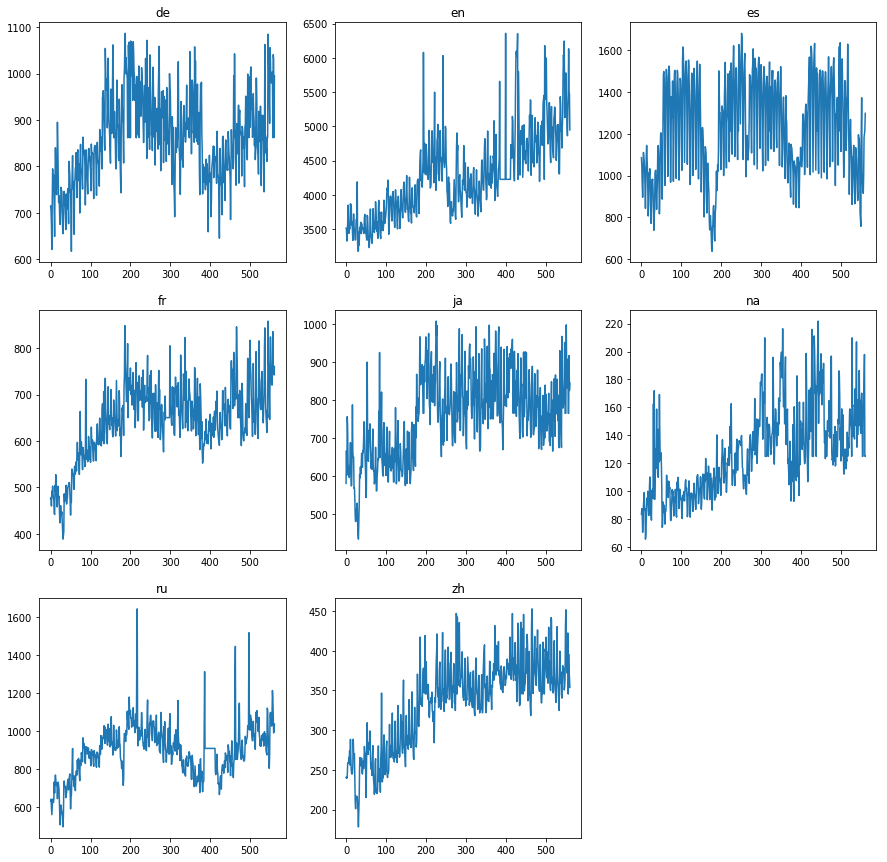

In [ ]:
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in lang_sets:
    plt.subplot(3, 3, i)
    plt.plot(lang_train[key])
    plt.title(key)
    i+=1

### Let's forcast with Prophet. 

I am using box cox transformation on the training dataset, because it works great with Prophet. I discovered that for English pages it doesn’t work properly.

-4.649176953855895


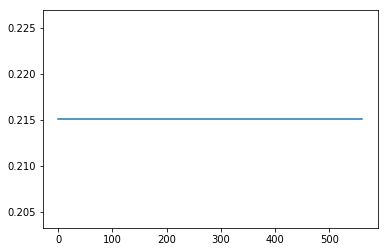

In [ ]:
a, lmbda_en = scs.boxcox(lang_train['en'])
print(lmbda_en)
plt.plot(a)
plt.show()

Lambda is getting very small and the result become strange. 
I found a workaround here https://github.com/scipy/scipy/issues/6873.

-1.192131020696936


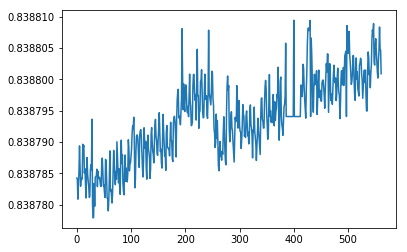

In [ ]:
lmax = scs.boxcox_normmax(lang_train['en'], brack=(-1.9, 2.0),  method='mle')
print(lmax)
plt.plot(scs.boxcox(lang_train['en'],lmax))
plt.show()

Without boxcox on English pages SMAPE and MAPE on test is around 4,3%. 

Which means that our pain with boxcox is worth doing.

We will perform predictions for different accesses and cite types, that is why here is a function. 

In [26]:
def Prophet_predict(sets, train,test,dt,lmax = 0):
    # for forecasts for each language
    forecast = {}
    #collecting our boxcox lambdas
    lmbda = {}
    
    for key in sets:
        print(key)
    
        df  = pd.DataFrame(train[key])
        # standart prophet requirement
        df.columns = ['y']
    
        if key != 'en':   
            df['y'], lmbda[key] = scs.boxcox(df.y) 
        else:
            df['y'] = scs.boxcox(df.y,lmax)  
            lmbda['en'] = lmax
            
        df["ds"] = dt
    
        m = Prophet(yearly_seasonality=True,daily_seasonality=True)
        m.fit(df);
    
        # prediction for days
        future = m.make_future_dataframe(periods=n_test,freq = "d")
        forecast[key] = m.predict(future)
    
        # to calculate metrics we need to do inverce boxcox
        MSE_test = mean_squared_error(test[key].values,\
                                           invboxcox(forecast[key].yhat.values[:-n_train],lmbda[key]))
        MSE_train = mean_squared_error(train[key],\
                                             invboxcox(forecast[key][:n_train].yhat.values,lmbda[key]))
        try:
            MAPE_test = mean_absolute_percentage_error(test[key].values,\
                                           invboxcox(forecast[key][:-n_train].yhat.values,lmbda[key]))
            MAPE_train = mean_absolute_percentage_error(train[key],\
                                       invboxcox(forecast[key][:n_train].yhat.values,lmbda[key]))
        except:
            MAPE_test = 'inf'
            MAPE_train = 'inf'
        
        
        SMAPE_test = smape_fast(test[key].values,\
                                       invboxcox(forecast[key][:-n_train].yhat.values,lmbda[key]))
        SMAPE_train = smape_fast(train[key],\
                                       invboxcox(forecast[key][:n_train].yhat.values,lmbda[key]))
        
    
        print("Test MSE %.2f" % MSE_test, "; ","Train MSE %.2f" % MSE_train)
        print("Test MAPE %.2f" % MAPE_test,"%; ", "Train MAPE %.2f" % MAPE_train,"%")
        print("Test SMAPE %.2f" % SMAPE_test,"%; ", "Train MSE %.2f" % SMAPE_train,"%")
        print('_____________________________________')
        
    return [forecast, lmbda]

# Results Prophet Languages

In [ ]:
[lang_forecast, lang_lmbda] = Prophet_predict(lang_sets, lang_train,lang_test,dt,lmax)

de
Test MSE 3337.46 ;  Train MSE 2584.59
Test MAPE 4.32 %;  Train MAPE 4.32 %
Test SMAPE 4.39 %;  Train MSE 4.31 %
_____________________________________
en
Test MSE 28859.35 ;  Train MSE 70724.77
Test MAPE 3.01 %;  Train MAPE 3.71 %
Test SMAPE 3.02 %;  Train MSE 3.75 %
_____________________________________
es
Test MSE 8145.40 ;  Train MSE 7595.38
Test MAPE 6.52 %;  Train MAPE 5.96 %
Test SMAPE 6.43 %;  Train MSE 5.90 %
_____________________________________
fr
Test MSE 1286.92 ;  Train MSE 1341.64
Test MAPE 4.38 %;  Train MAPE 4.41 %
Test SMAPE 4.37 %;  Train MSE 4.39 %
_____________________________________
ja
Test MSE 6132.06 ;  Train MSE 3437.96
Test MAPE 6.50 %;  Train MAPE 5.91 %
Test SMAPE 6.59 %;  Train MSE 5.87 %
_____________________________________
na
Test MSE 164.87 ;  Train MSE 298.42
Test MAPE 8.19 %;  Train MAPE 9.51 %
Test SMAPE 8.25 %;  Train MSE 9.56 %
_____________________________________
ru
Test MSE 5526.99 ;  Train MSE 6139.37
Test MAPE 5.79 %;  Train MAPE 5.83 %
Test

According to these results it works fine for all those pages. Except may be for 'na', which is media cites.

Let's see graphs on train datasets. 

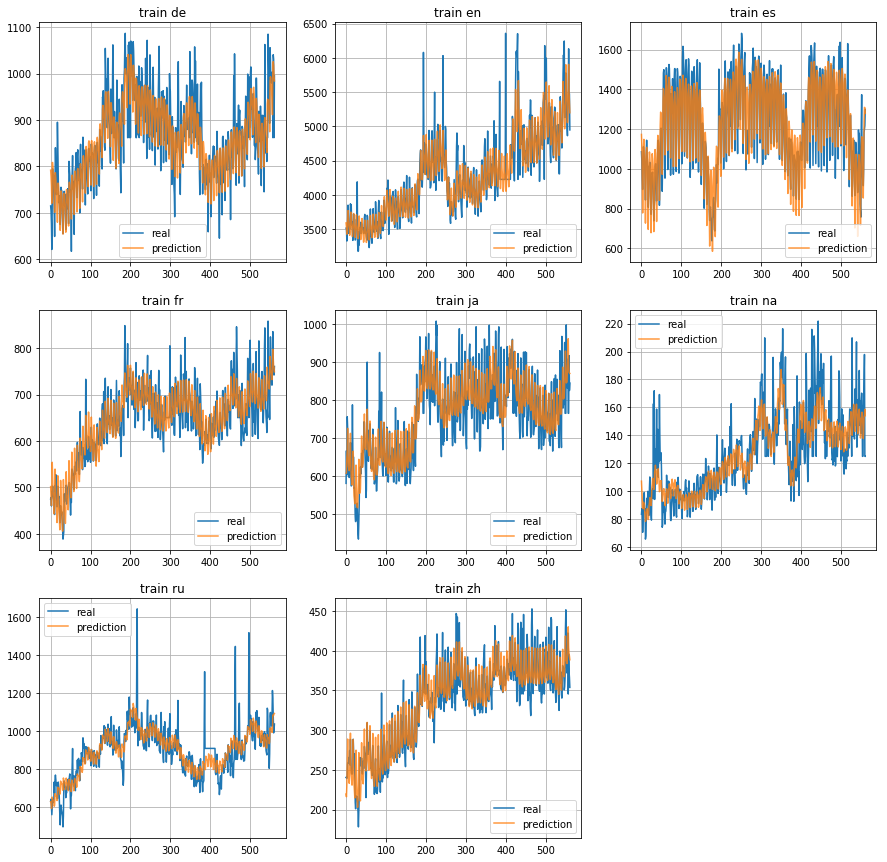

In [ ]:
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in lang_sets:
    plt.subplot(3, 3, i)
    plt.plot(lang_train[key])
    plt.plot(invboxcox(lang_forecast[key][:n_train].yhat.values,lang_lmbda[key]),alpha=0.8)
    plt.title('train '+key)
    plt.legend(['real','prediction'])
    plt.grid()
    i+=1
    


Let's see graphs on test datasets. 

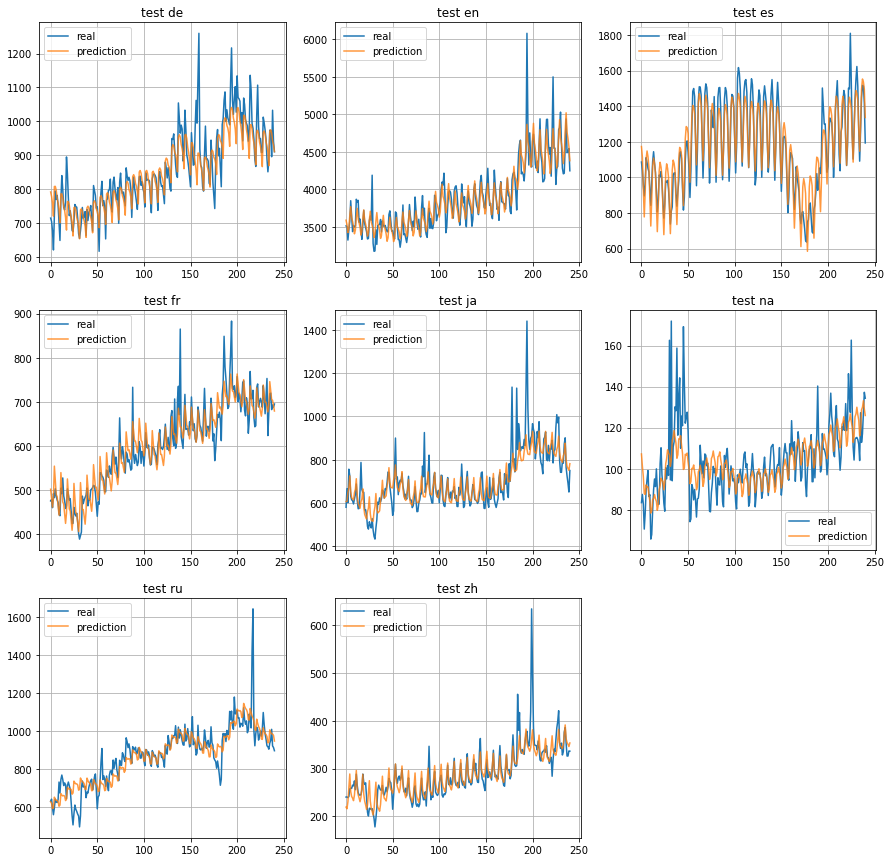

In [ ]:
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in lang_sets:
    plt.subplot(3, 3, i)
    plt.plot(lang_test[key].values)
    plt.plot(invboxcox(lang_forecast[key][:-n_train].yhat.values,lang_lmbda[key]),alpha = 0.8)
    plt.title('test '+key)
    plt.legend(['real','prediction'])
    plt.grid()
    i+=1

## Access_type

Here is the same scheme as for languages.
Calculating mean values of views for each group. 

In [ ]:
acc_sets = {}
for cat in train.access_type.cat.categories:
    acc_sets[cat] = train[train.access_type==cat]
    
acc_sum = {}
for key in acc_sets:
    # 0 - it is column Pages 
    # -1, -2 - language and acceess pages - we just cutting off some of the columns 
    acc_sum[key] = acc_sets[key].sum(axis=0)[1:-3] / acc_sets[key].shape[0]

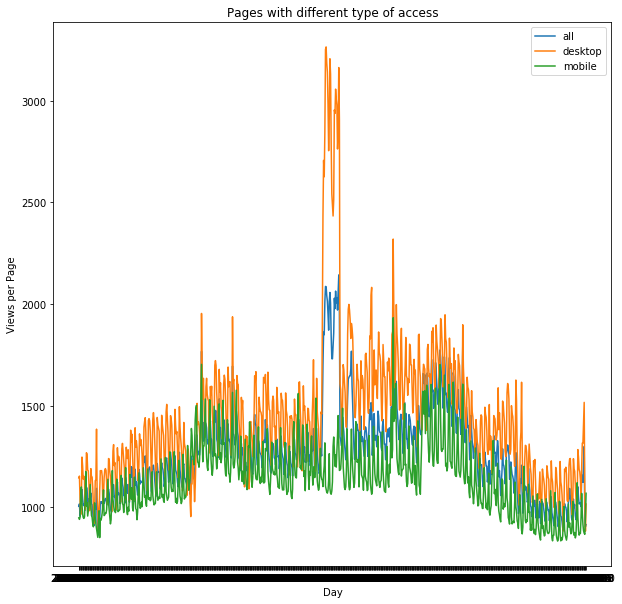

In [ ]:
fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages with different type of access')
plt.legend(list(train.access_type.cat.categories))

for key in acc_sum:
    plt.plot(acc_sum[key],label=key)
    
plt.legend()
plt.show()

These graphs seems pretty similar to me. However, what is interesting,  there is no huge pick for the mobile views.  

### Forecasting 

The same as for languages. Creating datasets, cleaning, predicting. 

In [ ]:
acc_test = {}
acc_train = {}

for key in acc_sets:
    acc_train[key] = acc_sum[key][:n_train]
    acc_test[key] = acc_sum[key][:-n_train] 
    acc_train[key] = acc_train[key].map(lambda x: float(x))
    acc_test[key] = acc_test[key].map(lambda x: float(x))

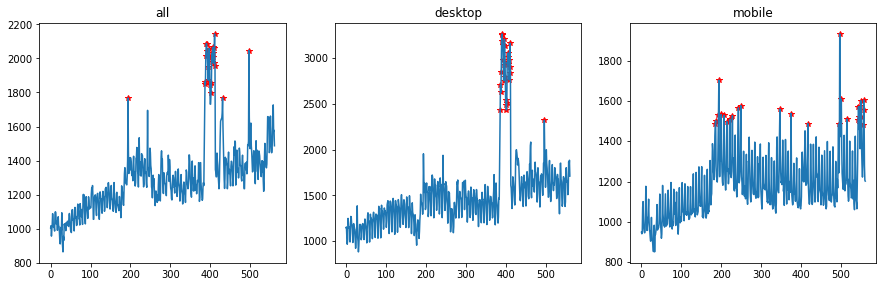

In [ ]:
median_acc = {}
mean_acc = {}
std_acc = {}
hight_picks_acc = {}
for key in acc_sets:
    median_acc[key] = np.median(acc_train[key])
    mean_acc[key] = np.mean(acc_train[key])
    std_acc[key] = np.std(acc_train[key])
    # it is for outliers 
    hight_picks_acc[key] = [acc_train[key][_] \
                        if abs(acc_train[key][_])>mean_acc[key]+2*std_acc[key] \
                        else np.nan for _ in range(n_train)]
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in acc_sets:
    plt.subplot(3, 3, i)
    plt.plot(hight_picks_acc[key],'r*') 
    plt.plot(acc_train[key].values)
    plt.title(key)
    i+=1

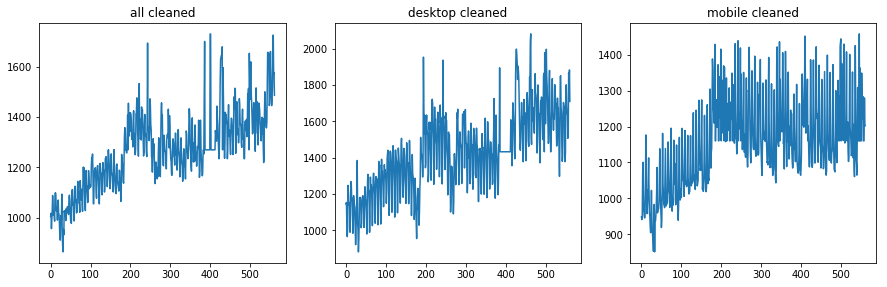

In [ ]:
# also we will save time 
# as we replacing object with the list
dt = acc_train['all'].index
for key in acc_sets:
    acc_train[key] = [median_acc[key]\
                       if abs(acc_train[key][_]) > mean_acc[key] + 2 * std_acc[key]\
                       else acc_train[key][_] 
                       for _ in range(n_train)]
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in acc_sets:
    plt.subplot(3, 3, i)
    plt.plot(acc_train[key])
    plt.title(key + " cleaned")
    i+=1

# Results Prophet Access

In [ ]:
[acc_forecast, acc_lmbda] = Prophet_predict(acc_sets, acc_train,acc_test,dt)

all
Test MSE 2441.66 ;  Train MSE 4608.80
Test MAPE 3.07 %;  Train MAPE 3.46 %
Test SMAPE 3.08 %;  Train MSE 3.49 %
_____________________________________
desktop
Test MSE 4359.88 ;  Train MSE 6675.07
Test MAPE 3.80 %;  Train MAPE 3.98 %
Test SMAPE 3.79 %;  Train MSE 3.98 %
_____________________________________
mobile
Test MSE 3964.00 ;  Train MSE 4155.41
Test MAPE 3.35 %;  Train MAPE 3.89 %
Test SMAPE 3.42 %;  Train MSE 3.88 %
_____________________________________


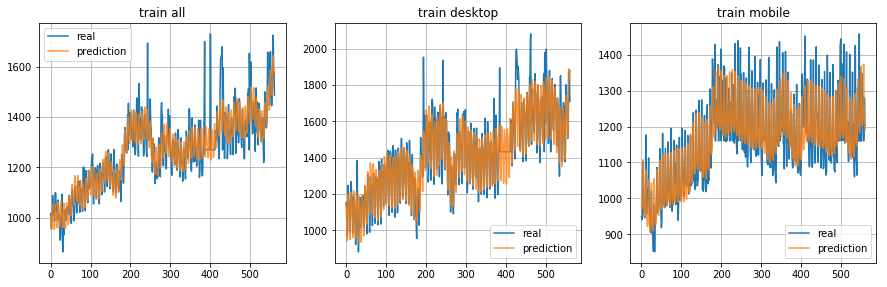

In [ ]:
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in acc_sets:
    plt.subplot(3, 3, i)
    plt.plot(acc_train[key])
    plt.plot(invboxcox(acc_forecast[key][:n_train].yhat.values,acc_lmbda[key]),alpha=0.8)
    plt.title('train '+key)
    plt.legend(['real','prediction'])
    plt.grid()
    i+=1

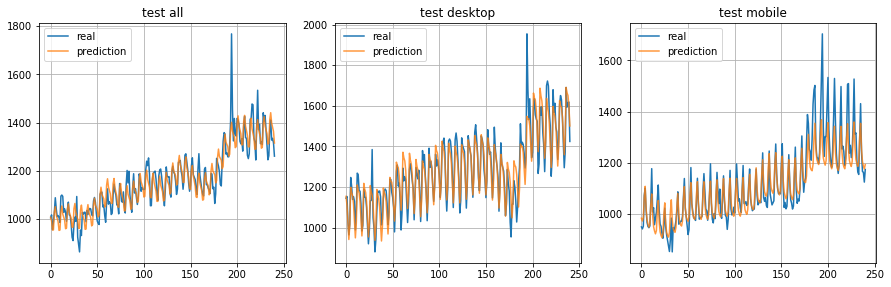

In [ ]:
i = 1
fig = plt.figure(1,figsize=[15,15])
for key in acc_sets:
    plt.subplot(3, 3, i)
    plt.plot(acc_test[key].values)
    plt.plot(invboxcox(acc_forecast[key][:-n_train].yhat.values,acc_lmbda[key]),alpha = 0.8)
    plt.title('test '+key)
    plt.legend(['real','prediction'])
    plt.grid()
    i+=1

Results are pretty good and for all three types of access quality of prediction is similar. 

Except for big picks predictions of the trend and preriodic behavior is good. 

The same as in two previous ones. Creating datasets, cleaning, predicting. 

In [18]:
cite_sets = {}
for cat in train.cite_type.cat.categories:
    cite_sets[cat] = train[train.cite_type==cat]
    
cite_sum = {}
for key in cite_sets:
    # 0 - it is column Pages 
    # -1, -2 - language and acceess pages - we just cutting off some of the columns 
    cite_sum[key] = cite_sets[key].sum(axis=0)[1:-3] / cite_sets[key].shape[0]

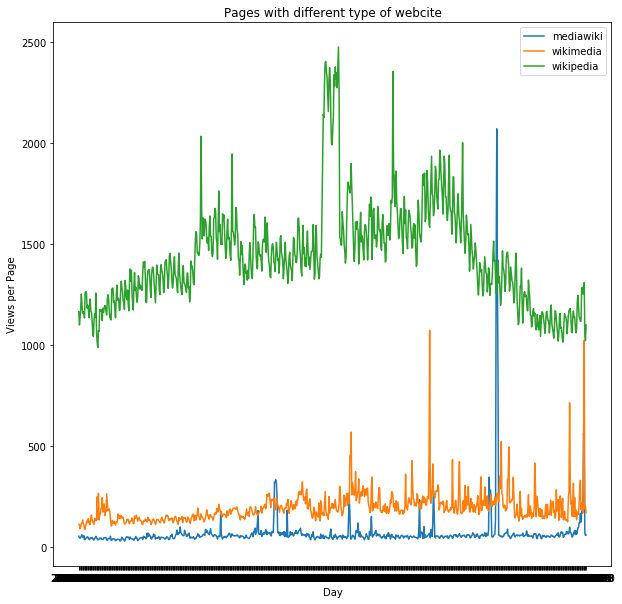

In [20]:
fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages with different type of webcite')
plt.legend(list(train.cite_type.cat.categories))

for key in cite_sum:
    plt.plot(cite_sum[key],label=key)
    
plt.legend()
plt.show()

Wikimedia and mediawiki looks a like because, apparently they are pretty much similar. 

However wikipedia pages follow English pages shape, simply because we have a lot of them in the wikipedia group. 


# LSTM

Let's try LSTM, to see if it gives better results. 

I performed LSTM not on the all the series, which were modelled in the previous section, but on the couple of them, 
to see if it performs better. 

In [28]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


We need to do scaling. As the boxcox was required for Prophet, here we use MinMax Scaler. 

In [32]:
lang_sum_lstm = {}
scaler = MinMaxScaler(feature_range = (0, 1))
#lang_train['en'] = scaler.fit_transform(lang_train['en'])
lang_sum_lstm['en'] = scaler.fit_transform(lang_sum['en'].values.reshape(-1, 1))

In [33]:
train = lang_sum_lstm['en'][:n_train]
test = lang_sum_lstm['en'][:-n_train]

We will delete picks again. Without it, the results are worse.  

In [35]:
m = np.mean(train)
std = np.std(train)
med = np.median(train)

train = [[med] if abs(train[_]) > m +  2 * std else [train[_][0]] for _ in range(n_train)]

In [36]:
train = np.array(train)

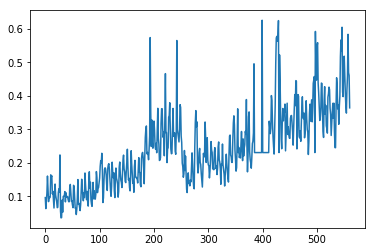

In [37]:
plt.plot(train)

In [38]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [39]:
# Create test and training sets for one-step-ahead regression.
window_size = 50
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(510, 50)
New training data shape:
(510, 1, 50)


In [40]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = [mean_squared_error(orig_data[0], pred[:, 0]),\
             mean_absolute_percentage_error(orig_data[0], pred[:, 0]),
             smape_fast(orig_data[0], pred[:, 0])]
    return(score, pred)


In [41]:
# Fit the  model.
model_ = fit_model(train_X, train_Y, 50)

Epoch 1/100
 - 3s - loss: 0.0088
Epoch 2/100
 - 2s - loss: 0.0060
Epoch 3/100
 - 2s - loss: 0.0053
Epoch 4/100
 - 2s - loss: 0.0050
Epoch 5/100
 - 2s - loss: 0.0046
Epoch 6/100
 - 2s - loss: 0.0043
Epoch 7/100
 - 2s - loss: 0.0041
Epoch 8/100
 - 2s - loss: 0.0039
Epoch 9/100
 - 2s - loss: 0.0038
Epoch 10/100
 - 2s - loss: 0.0037
Epoch 11/100
 - 2s - loss: 0.0037
Epoch 12/100
 - 2s - loss: 0.0036
Epoch 13/100
 - 2s - loss: 0.0034
Epoch 14/100
 - 2s - loss: 0.0034
Epoch 15/100
 - 2s - loss: 0.0035
Epoch 16/100
 - 2s - loss: 0.0033
Epoch 17/100
 - 2s - loss: 0.0033
Epoch 18/100
 - 2s - loss: 0.0033
Epoch 19/100
 - 2s - loss: 0.0032
Epoch 20/100
 - 2s - loss: 0.0031
Epoch 21/100
 - 2s - loss: 0.0030
Epoch 22/100
 - 2s - loss: 0.0031
Epoch 23/100
 - 2s - loss: 0.0031
Epoch 24/100
 - 2s - loss: 0.0030
Epoch 25/100
 - 2s - loss: 0.0031
Epoch 26/100
 - 2s - loss: 0.0030
Epoch 27/100
 - 2s - loss: 0.0030
Epoch 28/100
 - 2s - loss: 0.0031
Epoch 29/100
 - 2s - loss: 0.0029
Epoch 30/100
 - 2s - lo

In [42]:
score_train, train_predict = predict_and_score(model_, train_X, train_Y)
score_test, test_predict = predict_and_score(model_, test_X, test_Y) 

print("Train: %.2f MSE" % score_train[0],"; %.2f MAPE" % score_train[1],"; %.2f SMAPE" % score_train[2])
print("Test: %.2f MSE" % score_test[0],"; %.2f MAPE" % score_test[1],"; %.2f SMAPE" % score_test[2])

Train: 66942.61 MSE ; 3.82 MAPE ; 3.83 SMAPE
Test: 33346.00 MSE ; 2.99 MAPE ; 3.00 SMAPE


With Prophet we had: 


Test MSE 28859.35 ;  Train MSE 70724.77

Test MAPE 3.01 %;  Train MAPE 3.71 %

Test SMAPE 3.02 %;  Train MSE 3.75 %


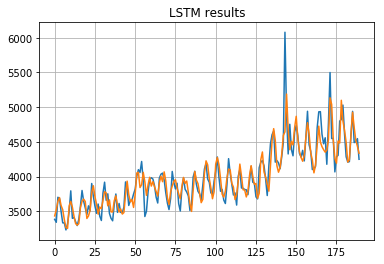

In [44]:
plt.plot(scaler.inverse_transform([test_Y])[0])
plt.plot(test_predict[:,0])
plt.title("LSTM results")
plt.grid()
plt.show()


So, LSTM is a bit better. Let's check the media pages, where we had around 8% MAPE. 

In [45]:
lang_sum_lstm['na'] = scaler.fit_transform(lang_sum['na'].values.reshape(-1, 1))
train_na = lang_sum_lstm['na'][:n_train]
test_na = lang_sum_lstm['na'][:-n_train]

In [47]:
m = np.mean(train_na)
std = np.std(train_na)
med = np.median(train_na)


train = [[med] if abs(train_na[_]) > m +  2 * std else [train_na[_][0]] for _ in range(n_train)]

In [48]:
train = np.array(train)

In [49]:
# Create test and training sets for one-step-ahead regression.
window_size = 50
train_X, train_Y = create_dataset(train_na, window_size)
test_X, test_Y = create_dataset(test_na, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(510, 50)
New training data shape:
(510, 1, 50)


In [50]:
# Fit the model.
model_ = fit_model(train_X, train_Y, 50)

Epoch 1/100
 - 3s - loss: 0.0019
Epoch 2/100
 - 2s - loss: 0.0015
Epoch 3/100
 - 2s - loss: 0.0014
Epoch 4/100
 - 2s - loss: 0.0014
Epoch 5/100
 - 2s - loss: 0.0013
Epoch 6/100
 - 2s - loss: 0.0013
Epoch 7/100
 - 2s - loss: 0.0013
Epoch 8/100
 - 2s - loss: 0.0013
Epoch 9/100
 - 1s - loss: 0.0013
Epoch 10/100
 - 2s - loss: 0.0013
Epoch 11/100
 - 2s - loss: 0.0012
Epoch 12/100
 - 2s - loss: 0.0012
Epoch 13/100
 - 2s - loss: 0.0012
Epoch 14/100
 - 2s - loss: 0.0012
Epoch 15/100
 - 2s - loss: 0.0012
Epoch 16/100
 - 2s - loss: 0.0012
Epoch 17/100
 - 2s - loss: 0.0012
Epoch 18/100
 - 2s - loss: 0.0012
Epoch 19/100
 - 2s - loss: 0.0011
Epoch 20/100
 - 1s - loss: 0.0012
Epoch 21/100
 - 2s - loss: 0.0011
Epoch 22/100
 - 2s - loss: 0.0011
Epoch 23/100
 - 2s - loss: 0.0011
Epoch 24/100
 - 1s - loss: 0.0011
Epoch 25/100
 - 2s - loss: 0.0011
Epoch 26/100
 - 2s - loss: 0.0011
Epoch 27/100
 - 2s - loss: 0.0011
Epoch 28/100
 - 1s - loss: 0.0011
Epoch 29/100
 - 2s - loss: 0.0011
Epoch 30/100
 - 2s - lo

In [52]:
score_train, train_predict = predict_and_score(model_, train_X, train_Y)
score_test, test_predict = predict_and_score(model_, test_X, test_Y) 

print("Train: %.2f MSE" % score_train[0],"; %.2f MAPE" % score_train[1],"; %.2f SMAPE" % score_train[2])
print("Test: %.2f MSE" % score_test[0],"; %.2f MAPE" % score_test[1],"; %.2f SMAPE" % score_test[2])

Train: 656.66 MSE ; 10.22 MAPE ; 10.10 SMAPE
Test: 117.08 MSE ; 7.76 MAPE ; 7.63 SMAPE


With Prophet we had:

na
Test MSE 164.87 ;  Train MSE 298.42

Test MAPE 8.19 %;  Train MAPE 9.51 %

Test SMAPE 8.25 %;  Train MSE 9.56 %

So, the results are almost one percent better. 